# Unlabeled flood videos from city cameras - Exploratory data analysis

---

In [32]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns; sns.set()

### Reload flood videos dataset

In [49]:
videos_control_path = '../Dados/Controle de vídeos/videos_control_2023-04-29.csv'

videos = pd.read_csv(videos_control_path)
videos['timestamp'] = pd.to_datetime(videos['timestamp'])

videos.columns

Index(['blob_name', 'blob_size', 'bucket_name', 'file_name', 'code',
       'n_folders', 'timestamp', 'folder_structure'],
      dtype='object')

### Reload flood images dataset

In [48]:
data_path = ''
images_control_path = f'../Dados/Controle de vídeos/images_control_2023-04-29.csv'

images = pd.read_csv(images_control_path)
images['timestamp'] = pd.to_datetime(images['timestamp'])

images.columns

Index(['blob_name', 'blob_size', 'bucket_name', 'file_name', 'code',
       'n_folders', 'timestamp', 'folder_structure', 'image_timestamp'],
      dtype='object')

---
## Exploratory data analsysis

In [50]:
def event_info(blob_name):
    "returns event type and event id given `blob_name` matching the folder structure `{source}/{type}/{event}/{code}`."
    info = blob_name.split('/')
    return ['/'.join(info[:2]), info[2]]

#### Cameras already recorded

In [51]:
print('Cameras recorded:', videos['code'].nunique())

Cameras recorded: 2430


In [53]:
print('Cameras recorded:', images['code'].nunique())

Cameras recorded: 193


#### Folder structure count

In [55]:
videos[['n_folders', 'folder_structure']].value_counts().sort_index()

n_folders  folder_structure                         
2          {type}/{code}                                21182
3          polygons/{type}/{code}                          69
           {type}/{subtype}/{code}                        478
4          polygons/{type}/{polygon}/{code}             11393
           {source}/{type}/{event}/{code}               10192
           {type}/{subtype}/{code}                         89
5          polygons/{source}/{type}/{polygon}/{code}      545
7          {type}/{subtype}/{code}                         88
dtype: int64

In [56]:
images[['n_folders', 'folder_structure']].value_counts().sort_index()

n_folders  folder_structure                         
3          {type}/{subtype}/{code}                       20473
4          polygons/{type}/{polygon}/{code}              50810
           {source}/{type}/{event}/{code}               138708
           {type}/{subtype}/{code}                        3727
5          polygons/{source}/{type}/{polygon}/{code}     19127
dtype: int64

#### Total events per type count

In [6]:
folder_structure_msk = control['folder_structure'] =='{source}/{type}/{event}/{code}'
event_cnt = control[folder_structure_msk]['blob_name'].apply(event_info).tolist()
event_cnt = pd.DataFrame(event_cnt, columns=['event_type', 'event_id'])

event_type_cnt = event_cnt.drop_duplicates()['event_type'].value_counts()

print(f'\n{event_type_cnt}\n')


waze/flood            612
comando/bolsão         50
comando/alagamento      7
comando/lâmina          5
Name: event_type, dtype: int64



#### Videos per camera

In [7]:
display(control["code"].value_counts().to_frame('Total Videos (top)').head(10).T)

,1487,278,3323,1462,1635,1636,1639,1638,482,262
Total Videos (top),531,526,438,268,254,251,250,243,239,220


#### Mega bytes (Mb) per camera

In [8]:
display(control.groupby("code")["blob_size"].sum().sort_values(ascending=False).to_frame('Total Mega Bytes').head(10).T / 1e6)

code,278,1487,482,3323,267,235,313,339,365,203
Total Mega Bytes,996.349552,495.083662,475.082134,380.590463,375.663969,361.612316,344.447743,333.281904,317.709037,313.130313


#### Dates recorded per camera (at least one video in date)

In [34]:
control_downloaded = control[control['folder_structure'].isin([
    '{source}/{type}/{event}/{code}',
    'polygons/{source}/{type}/{polygon}/{code}',
    'polygons/{type}/{polygon}/{code}',
    'polygons/{type}/{code}',
])]

dates = pd.Series(pd.DatetimeIndex(control_downloaded['timestamp']).date, name='date')
code_date_cnt = pd.concat([control_downloaded['code'], dates], axis=1).groupby('code')['date'].nunique()
code_date_cnt.sort_values(ascending=False).to_frame('Dates Recorded').head(15).T

code,1635.0,278.0,1648.0,262.0,339.0,267.0,77.0,1525.0,1534.0,1649.0,1524.0,1638.0,1636.0,1404.0,302.0
Dates Recorded,14,13,11,10,10,9,9,9,9,9,8,8,8,8,8


#### Distribution of dates recorded per camera

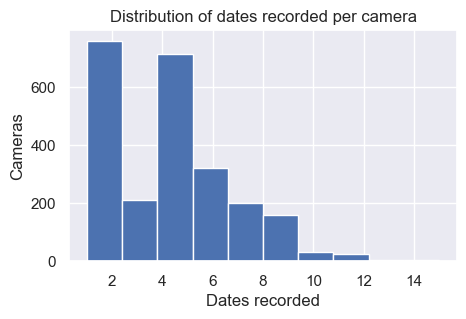

In [10]:
ax = code_date_cnt.sort_values(ascending=False).hist(figsize=(5, 3))
ax.set(
    title='Distribution of dates recorded per camera',
    xlabel='Dates recorded', ylabel='Cameras'
)
plt.show()

#### Total videos and bytes per day and cumulative

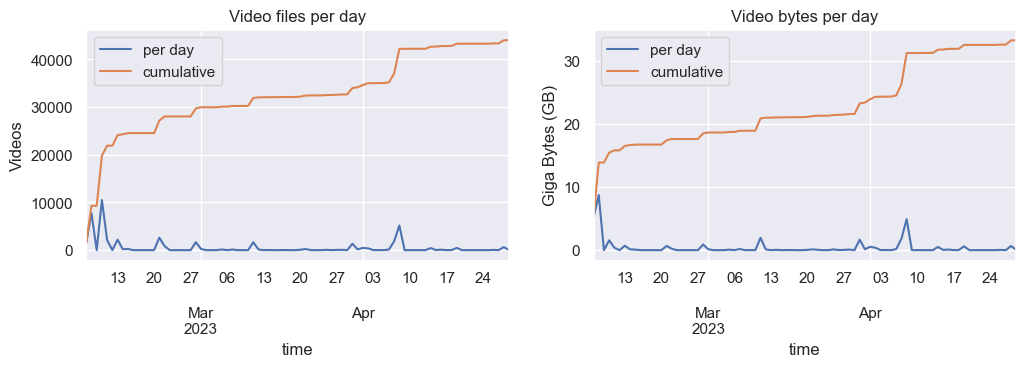

In [11]:
time_cnt = control.groupby('timestamp').count()['blob_name']
time_size_cnt = control.groupby('timestamp')['blob_size'].sum()

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

time_cnt.resample('1D').sum().plot(ax=axs[0])
time_cnt.resample('1D').sum().cumsum().plot(ax=axs[0])
axs[0].set(title='Video files per day', ylabel='Videos', xlabel='time')
axs[0].legend(['per day', 'cumulative'])

(time_size_cnt.resample('1D').sum() / 1e9).plot(ax=axs[1])
(time_size_cnt.resample('1D').sum().cumsum() / 1e9).plot(ax=axs[1])
axs[1].set(title='Video bytes per day', ylabel='Giga Bytes (GB)', xlabel='time')
axs[1].legend(['per day', 'cumulative'])
plt.show()

#### Recently recorded ·  Videos in past 30 days

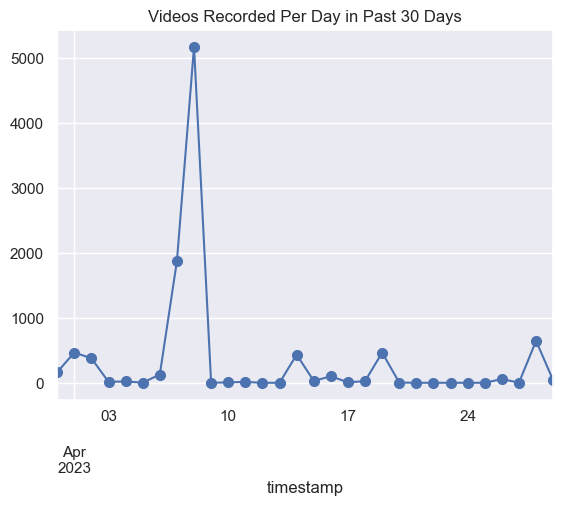

In [12]:
days = 30

ax = time_cnt.resample('1D').sum().tail(days).plot(marker='o', ms=7, title='Videos Recorded Per Day in Past 30 Days')

### Build videos datetime index

In [13]:
ts = control.set_index('timestamp') # datetime index

### Events per day

#### Extract event videos dataset

In [14]:
folder_structure_msk = ts['folder_structure'] =='{source}/{type}/{event}/{code}'

ts_events = ts[folder_structure_msk]

ts_events = pd.DataFrame(
    ts_events['blob_name'].map(event_info).tolist(),
    index=ts_events.index, columns=['event_type', 'event_id']
)

ts_events.head()

,event_type,event_id
timestamp,,
2023-03-30 19:55:06,comando/alagamento,93898
2023-03-30 20:00:09,comando/alagamento,93898
2023-03-30 20:05:10,comando/alagamento,93898
2023-03-30 20:10:13,comando/alagamento,93898
2023-03-30 20:15:12,comando/alagamento,93898


#### Events per type per day count

In [15]:
freq = '1D'

event_type_cnt = []
for event_type in ts_events['event_type'].unique():
    event_type_cnt.append(ts_events[ts_events['event_type']==event_type].resample(freq).nunique()['event_id'].rename(event_type))

event_type_cnt = pd.concat(event_type_cnt, axis=1).fillna(0.0)#.drop('rivers/manual', axis=1)

event_type_cnt.head()

,comando/alagamento,comando/bolsão,comando/lâmina,waze/flood
timestamp,,,,
2023-03-05,0.0,0.0,0.0,3
2023-03-06,0.0,0.0,0.0,0
2023-03-07,0.0,2.0,0.0,12
2023-03-08,0.0,0.0,0.0,0
2023-03-09,0.0,0.0,0.0,2


#### Events' videos per type per day count

In [16]:
freq = '1D'

event_videos_type_cnt = []
for event_type in ts_events['event_type'].unique():
    event_videos_type_cnt.append(ts_events[ts_events['event_type']==event_type].resample(freq).count()['event_id'].rename(event_type))

event_videos_type_cnt = pd.concat(event_videos_type_cnt, axis=1).fillna(0.0)#.drop('rivers/manual', axis=1)

event_videos_type_cnt.head()

,comando/alagamento,comando/bolsão,comando/lâmina,waze/flood
timestamp,,,,
2023-03-05,0.0,0.0,0.0,7
2023-03-06,0.0,0.0,0.0,0
2023-03-07,0.0,20.0,0.0,108
2023-03-08,0.0,0.0,0.0,0
2023-03-09,0.0,0.0,0.0,10


#### Events and videos per type per day · Line Chart

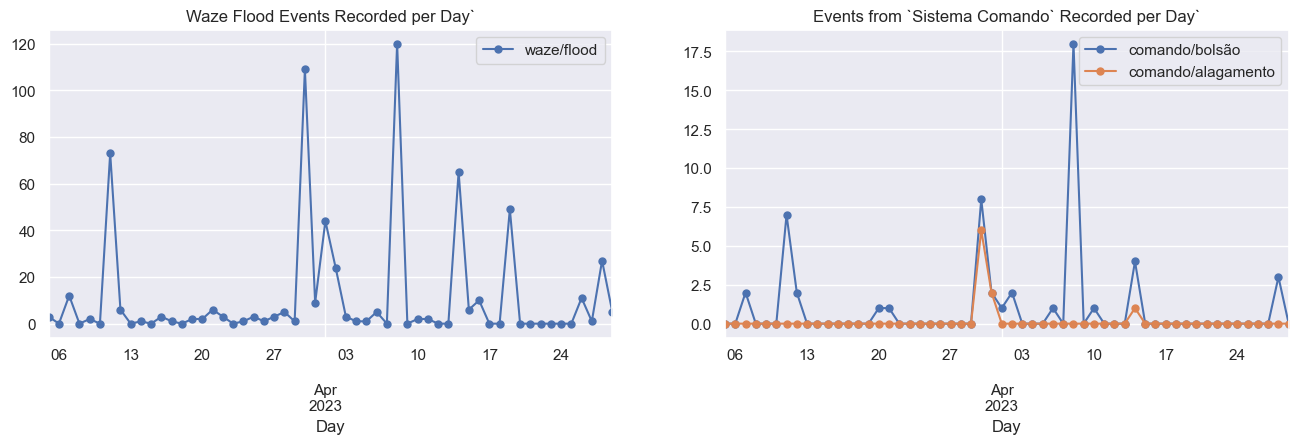

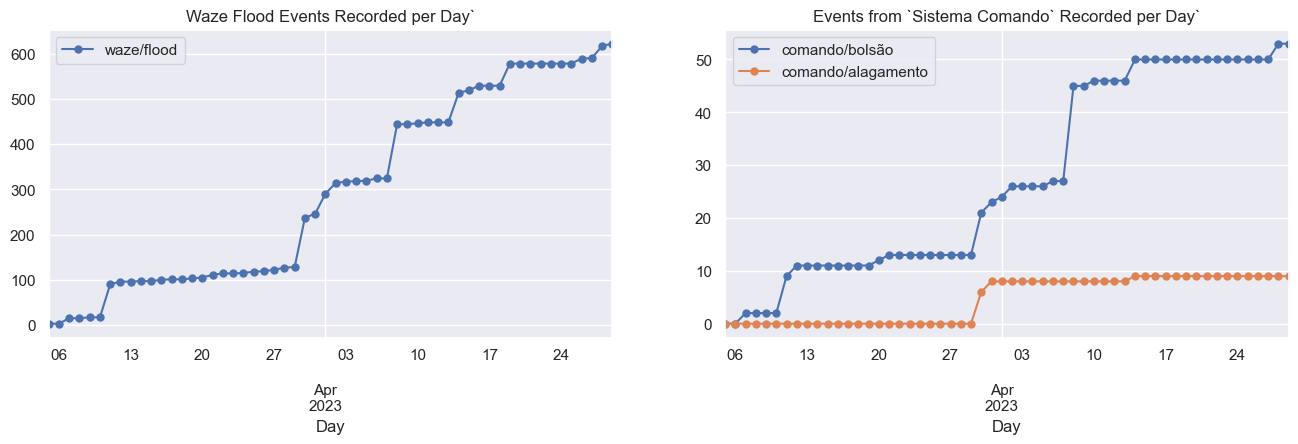

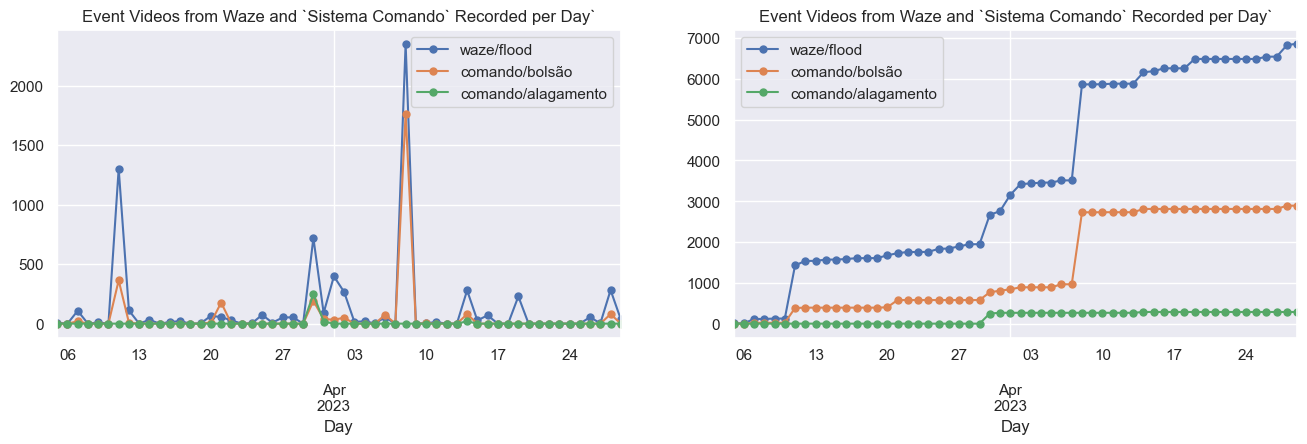

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
event_type_cnt[['waze/flood']].plot(
    ax=axs[0], marker='o', ms=5, xlabel='Day',
    title='Waze Flood Events Recorded per Day`'
)
event_type_cnt[['comando/bolsão', 'comando/alagamento']].plot(
    ax=axs[1], marker='o', ms=5, xlabel='Day',
    title='Events from `Sistema Comando` Recorded per Day`'
)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
event_type_cnt[['waze/flood']].cumsum().plot(
    ax=axs[0], marker='o', ms=5, xlabel='Day',
    title='Waze Flood Events Recorded per Day`'
)
event_type_cnt[['comando/bolsão', 'comando/alagamento']].cumsum().plot(
    ax=axs[1], marker='o', ms=5, xlabel='Day',
    title='Events from `Sistema Comando` Recorded per Day`'
)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
event_videos_type_cnt[['waze/flood', 'comando/bolsão', 'comando/alagamento']].plot(
    ax=axs[0], marker='o', ms=5, xlabel='Day',
    title='Event Videos from Waze and `Sistema Comando` Recorded per Day`'
)
event_videos_type_cnt[['waze/flood', 'comando/bolsão', 'comando/alagamento']].cumsum().plot(
    ax=axs[1], marker='o', ms=5, xlabel='Day',
    title='Event Videos from Waze and `Sistema Comando` Recorded per Day`'
)
plt.show()

Obs: An event count can be duplicated if the same event was recorded both before and after the midnight mark. Therefore, the chart values may vary slightly from the actual values.

---
### Cameras unique folder structures

#### River camera

In [31]:
control['folder_structure'][control['code']==1487].value_counts()

{type}/{subtype}/{code}             377
polygons/{type}/{polygon}/{code}    130
{type}/{code}                        24
Name: folder_structure, dtype: int64

#### Polygon camera

In [30]:
control['folder_structure'][control['code']==1475].value_counts()

polygons/{type}/{polygon}/{code}    180
{type}/{code}                        18
Name: folder_structure, dtype: int64

---
## Events and videos per type per period count

In [19]:
def event_info(blob_name):
    "returns event type and event id given `blob_name` matching the folder structure `{source}/{type}/{event}/{code}`."
    info = blob_name.split('/')
    return ['/'.join(info[:2]), info[2]]

def print_window_events(ts, start, end):
    ts_cut = ts[(ts.index >= start) & (ts.index < end)]
    folder_structure_msk = ts_cut['folder_structure'] =='{source}/{type}/{event}/{code}'
    event_cnt = ts_cut.loc[folder_structure_msk]['blob_name'].apply(event_info).tolist()
    event_cnt = pd.DataFrame(event_cnt, columns=['event_type', 'event_id'])
    video_cnt = event_cnt['event_type'].value_counts().rename('video_count')
    event_cnt = event_cnt.drop_duplicates()['event_type'].value_counts().rename('event_count')
    event_cnts = pd.concat([event_cnt, video_cnt], axis=1)
    display(event_cnts)

#### Build videos datetime index

In [20]:
ts = control.set_index('timestamp') # datetime index

#### 2023-04-27 and 2023-04-29

In [21]:
print_window_events(ts, start='2023-04-28', end='2023-04-29')

,event_count,video_count
waze/flood,27,282
comando/bolsão,3,80


#### 2023-04-07 and 2023-04-08

In [22]:
print_window_events(ts, start='2023-04-07', end='2023-04-09')

,event_count,video_count
waze/flood,120,2353
comando/bolsão,18,1764
comando/lâmina,2,126


#### 2023-03-30 and 2023-03-31

In [23]:
print_window_events(ts, start='2023-03-30', end='2023-04-01')

,event_count,video_count
waze/flood,114,810
comando/bolsão,9,230
comando/alagamento,6,266


#### 2023-04-18 and 2023-04-19

In [24]:
print_window_events(ts, start='2023-04-19', end='2023-04-20')

,event_count,video_count
waze/flood,49,229


---
## Cameras with highest number of flood events

In [25]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns; sns.set()

#### Get event types

In [26]:
def get_event_info(blob_name):
    "returns event type and event id given `blob_name` matching the folder structure `{source}/{type}/{event}/{code}`."
    info = blob_name.split('/')
    if len(info) != 5 or info[0] == 'polygons': return ['', '']
    return ['/'.join(info[:2]), info[2]]

#### Events recorded per câmera

In [27]:
# folder_structure_msk = control['folder_structure'] =='{source}/{type}/{event}/{code}'

event_info = control['blob_name'].apply(get_event_info).tolist()
control[['event_type', 'event_id']] = event_info

control_comando = control[control['event_type'].isin(['comando/bolsão', 'comando/alagamento'])]
events_per_code = control_comando.groupby('code')['event_id'].nunique()

cams_recurrence = events_per_code[events_per_code > 1]
display(cams_recurrence.sort_values(ascending=False).to_frame('Sistema Comando Events recorded').T)

print('Number of cameras with more than one recorded event from Sistema Comando database:', len(cams_recurrence))

code,38,1671,2015,1880,18,226,249,278,1726,1881,2165,2166,2167,2219,2220,2221
Sistema Comando Events recorded,5,5,5,3,2,2,2,2,2,2,2,2,2,2,2,2


Number of cameras with more than one recorded event from Sistema Comando database: 16


---
## Debugging

In [ ]:
videos